# Aquaseca basic domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import flopy.utils.binaryfile as bf


np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/flopy


## 2. Discretization and other inputs

In [2]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#ztop = 100
ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
#print(type(ztop))
#print(ztop.shape)
#print(ztop[0,:])
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction
#print(dz)

## Subsurface properties
K_horiz = 1.    #horizontal hydraulic conductivity 
K_vert = 1.    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET_1 = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
rip_ET= 5e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m
#print(ET_locxy)
#print(rip_loc)

# ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows

# ET_rows2=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols2=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx))

ET_rows_forced=(0.0, 50.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 50.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET_1 
#print("ET location(col, row)", ET_cols,ET_rows)
#print("ETrows_forced:", ET_rows_forced)
#print("ETrows:", ET_rows)
#print("ETcols:", ET_cols)
#print("ETrows2:", ET_rows2)
#print("ETcols2:", ET_cols2)

rip_rows_forced = (23.0, 29.0)  #forced riparian area
rip_cols_forced = (0.0, 50.0)


# rip_rows=(np.floor(nrow-rip_locxy[1][1]/dy),np.floor(nrow-rip_locxy[0][1]/dy)) #convert the y locations to rows
# rip_cols=(np.floor(rip_locxy[0][0]/dx),np.floor(rip_locxy[1][0]/dx)) #convert the y locations to rows
rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 
#print("Riparian location(col, row)", rip_cols,rip_rows)

## Recharge
rech=4e-5  #m/d
rechxy=[(0,0),(0,36000)]  #recharge zone

rech_rows_forced = (0.0, 50.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (0.0, 15.0)

rech_zone_forced = np.zeros((1,nrow,ncol))
rech_zone_forced[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech


rech_rows=(np.floor(nrow-rechxy[1][1]/dy),np.floor(nrow-rechxy[0][1]/dy))
rech_cols=(np.floor(rechxy[0][0]/dx),np.floor(rechxy[1][0]/dx))
rech_zone=np.zeros((1,nrow,ncol))
rech_zone[0,int(rech_rows[0]):int(rech_rows[1]),int(rech_cols[0]):int(rech_cols[1])]=rech
print("recharge location(col, row)", rech_cols,rech_rows)

## Well1: 
pumping1 = 0 #m3/day 
well_xy= [38000, 29000] #xy location of well 
well_row = np.floor((nrow)-(well_xy[1]/dy)) #convert the y location to a row
well_col=np.floor(well_xy[0]/dx) #convert the x location to a column
well_loc = (0,well_row, well_col) #Well loc shoudl be layer, row, column
print("well1 location(layer, col, row)", well_col, well_row)
#print(well1_loc)
#print(well1_col)
#print(well1_row)


## Well2 
#pumping = 0 #m3/day  
#well1_xy= [38000, 29000] #xy location of well 
#well1_row = np.floor((nrow-1)-(well1_xy[1]/dy)) #convert the y location to a row
#well1_col=np.floor(well1_xy[0]/dx-1) #convert the x location to a column
#well1_loc = (2,well1_row,well_col) #Well loc shoudl be layer, row, column
#print("well1 location(layer, col, row)", well1_col, well1_row)
#print(well1_loc)


## Well3 
#pumping = 0 #m3/day  
#well1_xy= [38000, 29000] #xy location of well 
#well1_row = np.floor((nrow-1)-(well1_xy[1]/dy)) #convert the y location to a row
#well1_col=np.floor(well1_xy[0]/dx-1) #convert the x location to a column
#well1_loc = (2,well1_row,well_col) #Well loc shoudl be layer, row, column
#print("well1 location(layer, col, row)", well1_col, well1_row)
#print(well1_loc)

# wel1 = [0, well1_col, well1_row, pumping1]
# wel1_spd = {0: [wel1]}
# print(wel1_spd)

## Boundary conditions
h_right = 70


## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

recharge location(col, row) (0.0, 0.0) (14.0, 50.0)
well1 location(layer, col, row) 38.0 21.0


## Seasons and Stessperiods

In [3]:
sp_peryr = 2   #number of seasons (with and wihtout ET. April-Sept and Oct-Mar)
sp1_len = 180  #sp lengths
sp2_len = 180
sim_years = 25
nper = int(sp_peryr*sim_years + 1)

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
#print(steady)
steady[0] = True    # initial stress period is steady-state

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)
perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen/10 #what's this line for???-abe
nstp[0]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)
print("Number of Steps", nstp)



Period lengths [ 10 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180]
Number of Steps [ 1 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18]


## Set up varying ET

In [4]:
ET_0 = 0
ET_SS = 1*ET_1/2

ET_val=np.tile([ET_1, ET_0],sim_years)
ET_val=np.append(ET_SS,ET_val)

ET = {}
for p in range(0,nper):    #loop over stress periods
    #print(ET_val[p])
    ET[p]=ET_zone*ET_val[p]
    print(np.sum(ET[p]))
print(ET[9])


1.2780000000000002e-07
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
2.5560000000000004e-07
0.0
[[[0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
   0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
   0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-10 1.e-10 1.e-10 1.e-10
   1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10 1.e-10
   1.e-10 

### Layering

In [5]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 


## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
#Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value
#Kz[1,:,:] = K_vert2
#print(K_horiz)
#print(Kz)

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 




## Boundary Conditions

In [6]:
#original BCS

#print(ibound)
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value
#########################

#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
#ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound[:,:,49] = -1          #replace rightmost column (all zs, all ys, first x) with 0 to indicate constant head
ibound[:,:,0] = 0.0            #replace leftmost column (all zs, all ys, first x) with 0 to indicate no flow
ibound[:,0,:] = 0         #replace bottom row (all zs, all ys, first x) with 0 to indicate no flow
ibound[:,49,:] = 0        #replace top row (all zs, all ys, first x) with 0 to indicate no flow

#bottom left corner
ibound[:,1,0:4] = 0
ibound[1:2,1,4:6] = 0
ibound[2,1,6:8] = 0

ibound[:,2,0:3] = 0
ibound[1:2,2,3:5] = 0
ibound[2,2,5:7] = 0

ibound[:,3,0:2] = 0
ibound[1:2,3,2:4] = 0
ibound[2,3,4:6] = 0

ibound[:,4,0:1] = 0
ibound[1,4,1:3] = 0
ibound[2,4,3:5] = 0

ibound[1,5,1:2] = 0
ibound[2,5,2:4] = 0

ibound[1,6,1] = 0
ibound[2,6,1:3] = 0

ibound[2,7,1:2] = 0

ibound[2,8,1] = 0

#top left (symmetrical)
ibound[:,48,0:4] = 0
ibound[1:2,48,4:6] = 0
ibound[2,48,6:8] = 0

ibound[:,47,0:3] = 0
ibound[1:2,47,3:5] = 0
ibound[2,47,5:7] = 0

ibound[:,46,0:2] = 0
ibound[1:2,46,2:4] = 0
ibound[2,46,4:6] = 0

ibound[:,45,0:1] = 0
ibound[1,45,1:3] = 0
ibound[2,45,3:5] = 0

ibound[1,44,1:2] = 0
ibound[2,44,2:4] = 0

ibound[1,43,1] = 0
ibound[2,43,1:3] = 0

ibound[2,42,1:2] = 0

ibound[2,41,1] = 0

#middle layer no flow region
ibound[1,42:49,0:7] = 0
#bottom layer no flow region
ibound[2,40:49,0:9] = 0

#setup initial heads as 1 everywhere except on the boundaries
#H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
#H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
#H_init[:, :, 0] = h_left    #replace first (left) col with desired head value
np.set_printoptions(threshold=np.inf)
#print(ET_zone.shape)
#print(ET_zone)

# print(ibound[0])
# print(ibound[1])
# print(ibound[2])

In [7]:
#DEFINE RIVERS
riv_row= 26
riv_sp = [] #create list to store all river cells for stress period 1
k_rivbott = 1 #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(dy)*(dx)/(sed_thick) #river bed conductance in m^2/d
r_stage = 0.5 #stage in river (stress period 1)
r_bott = ztop[25,:] #river bottom
#print(r_bott)
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+r_stage, cond, r_bott[i]-1])
    
print(riv_sp)
#create dictionary of stress period data
riv_spd = {0: riv_sp}
#print(riv_spd)

[[0, 26, 1, 98.5, 1000000.0, 98.0], [0, 26, 2, 97.5, 1000000.0, 97.0], [0, 26, 3, 96.5, 1000000.0, 96.0], [0, 26, 4, 95.5, 1000000.0, 95.0], [0, 26, 5, 94.5, 1000000.0, 94.0], [0, 26, 6, 93.5, 1000000.0, 93.0], [0, 26, 7, 92.5, 1000000.0, 92.0], [0, 26, 8, 91.5, 1000000.0, 91.0], [0, 26, 9, 90.5, 1000000.0, 90.0], [0, 26, 10, 89.5, 1000000.0, 89.0], [0, 26, 11, 88.5, 1000000.0, 88.0], [0, 26, 12, 87.5, 1000000.0, 87.0], [0, 26, 13, 86.5, 1000000.0, 86.0], [0, 26, 14, 85.5, 1000000.0, 85.0], [0, 26, 15, 84.5, 1000000.0, 84.0], [0, 26, 16, 83.5, 1000000.0, 83.0], [0, 26, 17, 82.5, 1000000.0, 82.0], [0, 26, 18, 81.5, 1000000.0, 81.0], [0, 26, 19, 80.5, 1000000.0, 80.0], [0, 26, 20, 79.5, 1000000.0, 79.0], [0, 26, 21, 78.5, 1000000.0, 78.0], [0, 26, 22, 77.5, 1000000.0, 77.0], [0, 26, 23, 76.5, 1000000.0, 76.0], [0, 26, 24, 75.5, 1000000.0, 75.0], [0, 26, 25, 75.4, 1000000.0, 74.9], [0, 26, 26, 75.3, 1000000.0, 74.8], [0, 26, 27, 75.2, 1000000.0, 74.7], [0, 26, 28, 75.1, 1000000.0, 74.6], 

In [8]:
#create model object
modelname = "Domain_setup"
#moddir="/Applications/MODFLOW/mf2005"
moddir = "/Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mf2005"
#moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp=nstp)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
#ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53) 

#Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone_forced, ipakcb=53)     #create rch object

#River - riv
riv = flopy.modflow.ModflowRiv(model=m, stress_period_data = riv_spd, ipakcb=53)

#Well - wel
#wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel1_spd)

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=200)

#write the inputs
m.write_input()    

#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')
    
m.riv.check()

FloPy is using the following  executable to run the model: /Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Domain_setup.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/16  9:03:34

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Sol

 Solving:  Stress period:    11    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    16    Ground-Wa

 Solving:  Stress period:    20    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    14    Ground-Wa

 Solving:  Stress period:    29    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     9    Ground-Wa

 Solving:  Stress period:    40    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    13    Ground-Wa

 Solving:  Stress period:    48    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     6    Ground-Wa

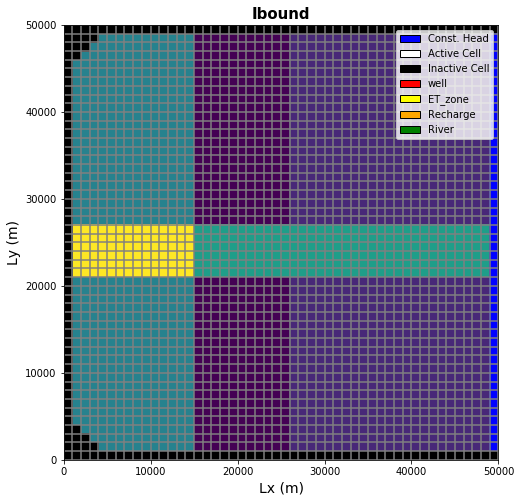

In [9]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m)
grid = modelmap.plot_grid()
zones = ET_zone + rech_zone_forced
quadmesh = modelmap.plot_array(zones)
#quadmesh = modelmap.plot_array(rech_zone_forced) #, color='purple')
#riv_plot = modelmap.plot_bc(ftype='RIV')
#chd_plot = modelmap.plot_bc(ftype='CHD')
#quadmesh = modelmap.plot_bc('WEL')
#quadmesh = modelmap.plot_array(win_sq_array)
#quadmesh = modelmap.plot_bc('WEL')
quadmesh = modelmap.plot_ibound()



#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                    mp.patches.Patch(color='red',label='well',ec='black'), 
                   mp.patches.Patch(color='yellow',label='ET_zone',ec='black'),
                    mp.patches.Patch(color='orange',label='Recharge',ec='black'),
                    mp.patches.Patch(color='green',label='River',ec='black')
                   ])

plt.show(modelmap)
#plt.savefig('Domaingrid.png')

In [10]:
hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times() # returns a list of timesteps

head = {} 
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')

for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
    #frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) #append right face flow to frf list for ea stress per
    #fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per

#headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
#head = headobj.get_alldata()
#head = headobj.get_data(totim=1.0)
#print(head)

#import 3d axes toolkit from matplotlib
#from mpl_toolkits.mplot3d import Axes3D

# #create 3d figure
# fig_3d = plt.figure(figsize=(12,5))
# ax = fig_3d.gca(projection='3d')

# #set X, Y, Z variables for 3d plot to be our model domain and head solution
# X = np.arange(0,Lx,dx)
# Y = np.arange(0,Ly,dy)
# X, Y = np.meshgrid(X, Y)
# Z = np.flipud(head[0])

# #create surface and labels
# surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head',masked_values=[-999.99])
# fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
# ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
# ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
# ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
# plt.show(surf)

# plt.figure(figsize=(9,9)) #create 10 x 10 figure
# modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
# #riv_plot = modelmap.plot_bc(ftype='RIV') #plot river cells
# #chd_plot = modelmap.plot_bc(ftype='CHD') #plot ghb cells
# contour_levels = np.linspace(head[0].min(),head[0].max(),1) #set contour levels for contouring head
# head_contours = modelmap.contour_array(head[0],masked_values=[-999.99], levels=contour_levels) #create head contours
# #flows = modelmap.plot_discharge(frf['sp%s'%i][0], fff['sp%s'%i][0], head=head['sp%s'%i]) #create discharge arrows
# #display parameters
# plt.xlabel('Lx (m)',fontsize = 14)
# plt.ylabel('Ly (m)',fontsize = 14)
# plt.title('Head', fontsize = 13, fontweight = 'bold')
# plt.colorbar(head_contours, aspect=5)
# plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'), 
#                    mp.patches.Patch(color='navy',label='Constant Head Boundary',ec='black'),
#                    mp.patches.Patch(color='white',label='Active Cell',ec='black')],
#                    bbox_to_anchor=(1.8,1.0)) #create legend
# plt.show(modelmap)    

TypeError: unhashable type: 'slice'

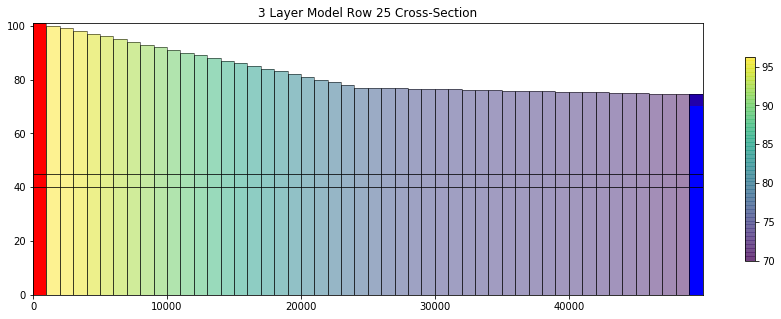

In [11]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')

pc = xsect.plot_array(head['sp0'], masked_values=[-999.99], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head['sp0'])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head[0,:,:], masked_values=[999.], color='blue', lw=1)

## Plotting Heads

In [ ]:

#plot a time series at cell left of river
#get time series for cell
print(well_loc)
cell_id1 = well_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at Well",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record
plt.show()
#plt.savefig("Head_Field_Center_ETSS.png")

In [ ]:
well_loc
head['sp0'][0][19][38]
#head['sp0'][well_loc[0]][well_loc[1]][well_loc[2]]

